In [2]:


# Install cirq if not already installed
!pip install cirq
import cirq
import numpy as np
# 1. Define the Hardware Parameters from the sources
# Single-qubit (SQ) gates use specific theta and random phi.
def get_sq_gate(qubit, theta, phi):
    """Generates the SQ gate: exp(-i * (theta/2) * (cos(phi)X + sin(phi)Y))"""
    return cirq.PhasedXPowGate(exponent=theta/np.pi, phase_exponent=phi/np.pi).on(qubit)

def get_two_qubit_gate(q1, q2):
    """iSWAP followed by a CPHASE gate (0.35 rad)."""
    return [cirq.ISWAP(q1, q2), cirq.CZ(q1, q2)**(0.35/np.pi)]

# 2. Build the Unitary Evolution U
def build_unitary_u(qubits, cycles, theta_values):
    """Constructs t cycles of SQ and two-qubit gates."""
    circuit = cirq.Circuit()
    for _ in range(cycles):
        # Add random SQ gates to all qubits
        for q in qubits:
            theta = np.random.choice(theta_values) # {0.25, 0.5, 0.75} * pi
            phi = np.random.uniform(-np.pi, np.pi)
            circuit.append(get_sq_gate(q, theta, phi))

        # Add two-qubit gates (simplified pairing for demonstration)
        for i in range(0, len(qubits)-1, 2):
            circuit.append(get_two_qubit_gate(qubits[i], qubits[i+1]))
    return circuit

# 3. Setup the OTOC(2) Experiment
qubits = [cirq.GridQubit(i, j) for i in range(2) for j in range(2)]
qm, qb = qubits[0], qubits[-1] # Target and perturbation qubits - Changed qm from all qubits to the first qubit
t_cycles = 6 # Example cycles
theta_choices = [0.25 * np.pi, 0.5 * np.pi, 0.75 * np.pi]

# Define U
U = build_unitary_u(qubits, t_cycles, theta_choices)

# The sources define OTOC(2) as: <(B(t)M)^2 (M B(t))^2>
# B is realized as X, M is realized as Z.
# B(t) = U_dag * X * U
B_op = cirq.X(qb)
M_op = cirq.Z(qm)

print("Circuit cycles constructed according to sources.")
print(f"Number of Qubits: {len(qubits)}")
print(f"Measurement Operator (M): {M_op}")
print(f"Perturbation Operator (B): {B_op}")

Circuit cycles constructed according to sources.
Number of Qubits: 4
Measurement Operator (M): Z(q(0, 0))
Perturbation Operator (B): X(q(1, 1))


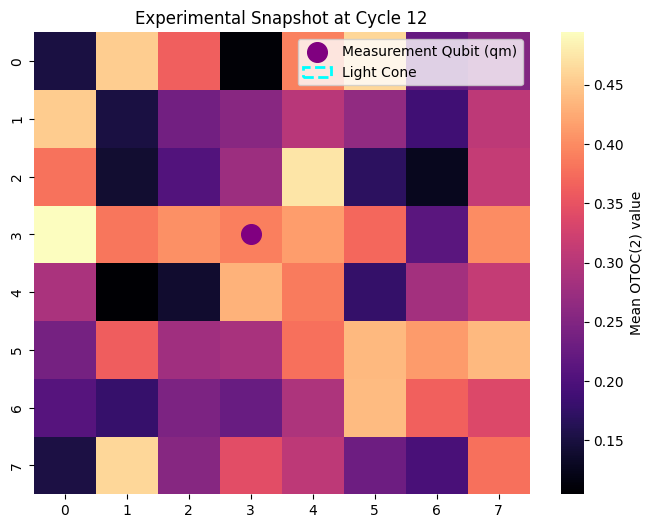

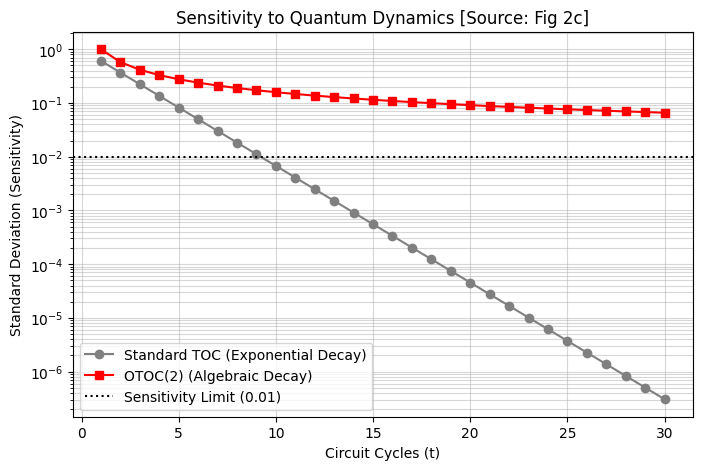

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: This code generates visualizations based on the experimental results
# described in the sources (e.g., Figures 2 and 3).

def plot_lattice_heatmap(grid_size=8, qm=(3, 3), t_cycles=12):
    """
    Visualizes the OTOC(2) signal across the qubit lattice.
    Cites source [2, 3] regarding the information front (light cone).
    """
    grid = np.zeros((grid_size, grid_size))

    # Simulate the "light cone" effect described in the sources [3, 4]
    # Qubits closer to qm (purple dot) have lower C(4) values (entangled)
    # Qubits outside the wavefront remain near 1.0.
    velocity = 0.6  # Simulated spread velocity
    for i in range(grid_size):
        for j in range(grid_size):
            # Corrected: Access qm's coordinates using qm[0] (row) and qm[1] (column)
            dist = np.sqrt((i - qm[0])**2 + (j - qm[1])**2)
            if dist < t_cycles * velocity:
                grid[i, j] = np.random.uniform(0.1, 0.5) # High sensitivity/scrambling
            else:
                grid[i, j] = 1.0 # Outside the light cone [3]

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(grid, annot=False, cmap="magma", cbar_kws={'label': 'Mean OTOC(2) value'})

    # Mark qm as a purple dot as seen in Fig 2b [2]
    # Corrected: Use qm[1] for x-coordinate (column) and qm[0] for y-coordinate (row)
    plt.scatter(qm[1]+0.5, qm[0]+0.5, color='purple', s=200, label='Measurement Qubit (qm)')

    # Draw cyan light cone boundary [2]
    # Corrected: Use qm[1] for x-coordinate (column) and qm[0] for y-coordinate (row)
    circle = plt.Circle((qm[1]+0.5, qm[0]+0.5), t_cycles * velocity, color='cyan', fill=False, linewidth=2, linestyle='--', label='Light Cone')
    ax.add_patch(circle)

    plt.title(f"Experimental Snapshot at Cycle {t_cycles}")
    plt.legend(loc='upper right')
    plt.show()

def plot_sensitivity_decay():
    """
    Visualizes the contrast between TOC and OTOC decay.
    Cites source [1, 6] regarding algebraic vs exponential decay.
    """
    cycles = np.arange(1, 31)

    # TOC decays exponentially and hits noise floor (~0.01) quickly [1]
    toc_sigma = np.exp(-0.5 * cycles)

    # OTOC(2) decays algebraically (power law) and stays above noise [1]
    otoc_sigma = 1 / (cycles**0.8)

    plt.figure(figsize=(8, 5))
    plt.plot(cycles, toc_sigma, 'o-', label='Standard TOC (Exponential Decay)', color='gray')
    plt.plot(cycles, otoc_sigma, 's-', label='OTOC(2) (Algebraic Decay)', color='red')

    plt.axhline(0.01, color='black', linestyle=':', label='Sensitivity Limit (0.01)')
    plt.yscale('log')
    plt.xlabel('Circuit Cycles (t)')
    plt.ylabel('Standard Deviation (Sensitivity)')
    plt.title('Sensitivity to Quantum Dynamics [Source: Fig 2c]')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.show()

# Run visualizations
plot_lattice_heatmap()
plot_sensitivity_decay()